<a href="https://colab.research.google.com/github/Shriniwas21/CryptoPricePrediction/blob/main/01_data_collection_and_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
!pip install yfinance

In [84]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define path to the dataset in Drive
data_path = '/content/drive/MyDrive/CryptoPricePrediction/data'
btc_path = os.path.join(data_path, 'BTC_day.csv')  # update filename if different

# Load the CSV file
btc = pd.read_csv(btc_path)

# Show first few rows
btc.head()

,timestamp,open,close,high,low,volume
0,1569196800,9930.13,9930.13,9930.13,9930.13,0.001000
1,1569283200,9637.93,8519.67,9665.05,7996.45,202.350799
2,1569369600,8528.12,8435.28,8724.77,8247.78,55.417971
3,1569456000,8434.45,8064.41,8453.20,7761.87,41.880079
4,1569542400,8078.75,8178.73,8259.96,7858.58,47.142904


In [85]:
btc.columns = btc.columns.str.strip().str.lower()  # normalize column names
print(btc.columns.tolist())  # should show all lowercase names

['timestamp', 'open', 'close', 'high', 'low', 'volume']


In [86]:
# Re-read the file in case you're mid-session
btc = pd.read_csv(btc_path)

# Convert timestamp from nanoseconds to datetime
btc['date'] = pd.to_datetime(btc['timestamp'], unit='s')

# Set as index
btc.set_index('date', inplace=True)

# Drop old timestamp column
btc.drop(columns=['timestamp'], inplace=True)

# Sort by date
btc.sort_index(inplace=True)

print(f"Start date: {btc.index.min()}")
print(f"End date: {btc.index.max()}")

btc.head()

Start date: 2019-09-23 00:00:00
End date: 2024-05-09 00:00:00


,open,close,high,low,volume
date,,,,,
2019-09-23,9930.13,9930.13,9930.13,9930.13,0.001000
2019-09-24,9637.93,8519.67,9665.05,7996.45,202.350799
2019-09-25,8528.12,8435.28,8724.77,8247.78,55.417971
2019-09-26,8434.45,8064.41,8453.20,7761.87,41.880079
2019-09-27,8078.75,8178.73,8259.96,7858.58,47.142904


In [87]:
print("Shape for crypto dataset:", btc.shape)

Shape for crypto dataset: (1691, 5)


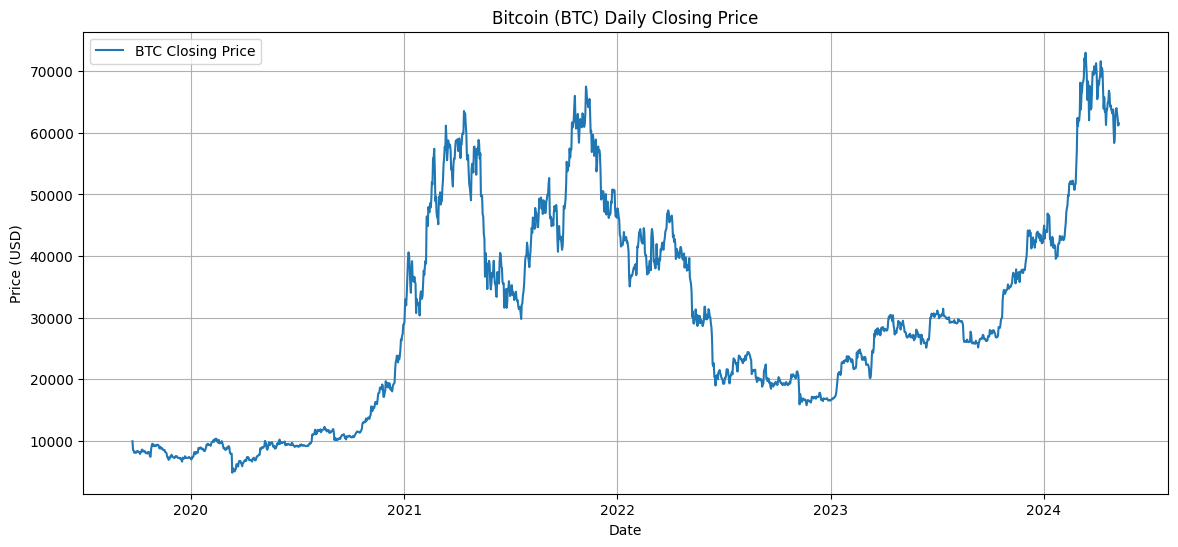

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(btc.index, btc['close'], label='BTC Closing Price')
plt.title('Bitcoin (BTC) Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [89]:
#Crypto start and end date
btc_start = "2019-09-23"
btc_end = "2024-05-09"


import yfinance as yf

btc_yf_pre = yf.download("BTC-USD", start="2014-01-01", end=btc_start)
print("Pre 2019 dataset shape:", btc_yf_pre.shape)
btc_yf_post = yf.download("BTC-USD", start=btc_end, end="2025-01-01")
print("Post 2024 dataset shape:", btc_yf_post.shape)

def clean_yf(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df.columns = df.columns.str.lower()
    return df[['open', 'high', 'low', 'close', 'volume']]

btc_yf_pre = clean_yf(btc_yf_pre)
btc_yf_post = clean_yf(btc_yf_post)

btc_full = pd.concat([btc_yf_pre, btc, btc_yf_post])
btc_full = btc_full[~btc_full.index.duplicated(keep='last')]

print("Merged dataset shape:", btc_full.shape)
print("Start:", btc_full.index.min())
print("End:", btc_full.index.max())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Pre 2019 dataset shape: (1832, 5)
Post 2024 dataset shape: (237, 5)
Merged dataset shape: (3759, 5)
Start: 2014-09-17 00:00:00
End: 2024-12-31 00:00:00


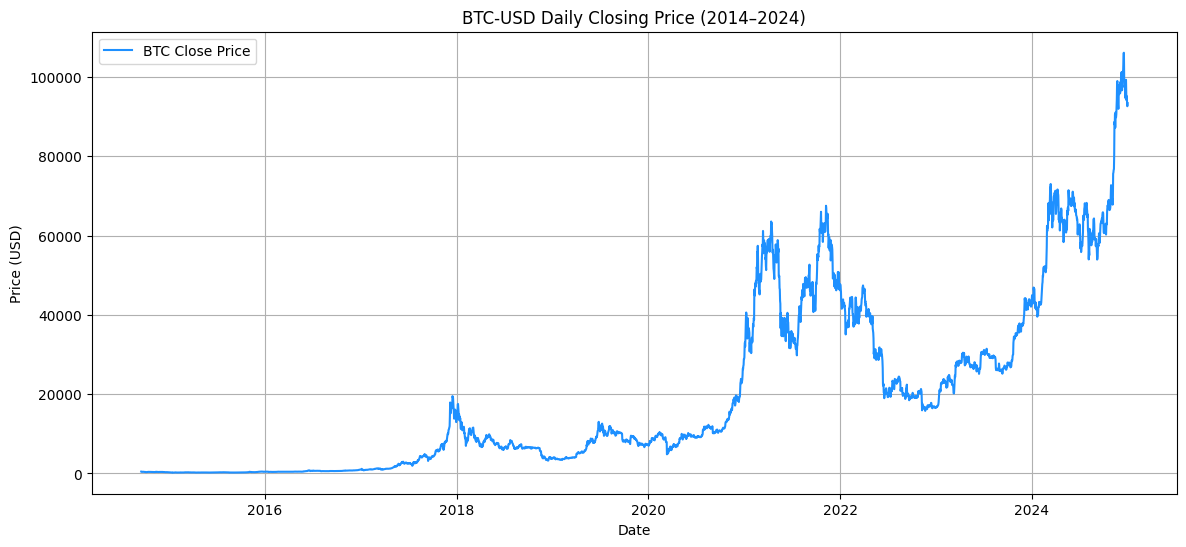

In [90]:
plt.figure(figsize=(14, 6))
plt.plot(btc_full.index, btc_full['close'], label='BTC Close Price', color='dodgerblue')
plt.title('BTC-USD Daily Closing Price (2014–2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

In [91]:
btc_yf_pre.to_csv('/content/drive/MyDrive/CryptoPricePrediction/data/btc_yf_pre.csv')
btc_yf_post.to_csv('/content/drive/MyDrive/CryptoPricePrediction/data/btc_yf_post.csv')
btc_full.to_csv('/content/drive/MyDrive/CryptoPricePrediction/data/btc_full_merged.csv')

In [92]:
# Simple & exponential moving averages
btc_full['sma_7'] = btc_full['close'].rolling(window=7).mean()
btc_full['sma_21'] = btc_full['close'].rolling(window=21).mean()
btc_full['ema_7'] = btc_full['close'].ewm(span=7, adjust=False).mean()
btc_full['ema_21'] = btc_full['close'].ewm(span=21, adjust=False).mean()

# RSI
delta = btc_full['close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
btc_full['rsi_14'] = 100 - (100 / (1 + rs))

# Daily return
btc_full['daily_return'] = btc_full['close'].pct_change()

# Volatility and price movement
btc_full['high_low_spread'] = btc_full['high'] - btc_full['low']
btc_full['close_open_diff'] = btc_full['close'] - btc_full['open']

# Time features
btc_full['dayofweek'] = btc_full.index.dayofweek
btc_full['month'] = btc_full.index.month
btc_full['is_weekend'] = (btc_full['dayofweek'] >= 5).astype(int)

print("Updated dataset shape:", btc_full.shape)

Updated dataset shape: (3759, 16)


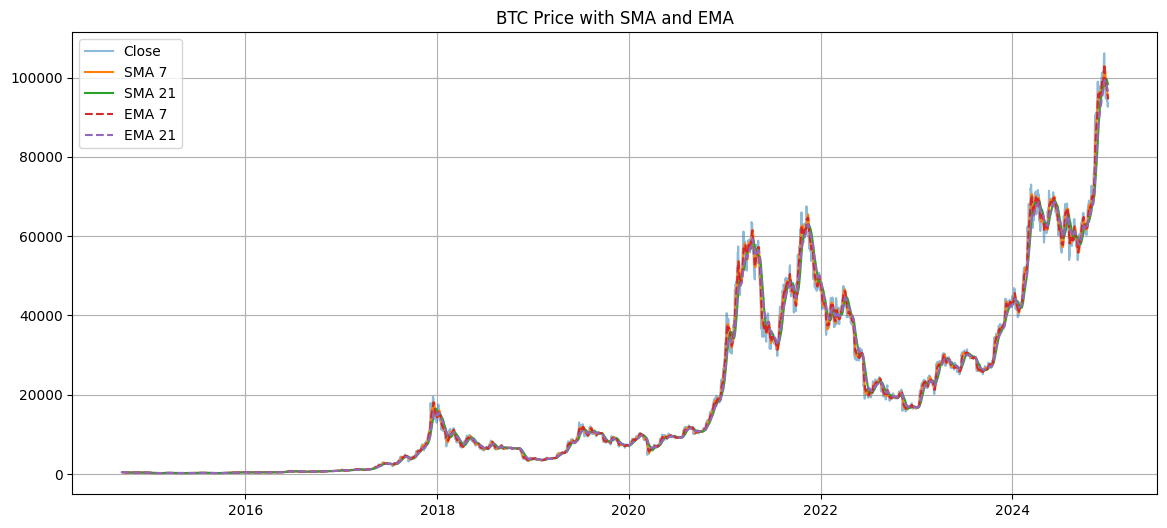

In [93]:
plt.figure(figsize=(14, 6))
plt.plot(btc_full['close'], label='Close', alpha=0.5)
plt.plot(btc_full['sma_7'], label='SMA 7')
plt.plot(btc_full['sma_21'], label='SMA 21')
plt.plot(btc_full['ema_7'], label='EMA 7', linestyle='--')
plt.plot(btc_full['ema_21'], label='EMA 21', linestyle='--')
plt.title('BTC Price with SMA and EMA')
plt.legend()
plt.grid(True)
plt.show()

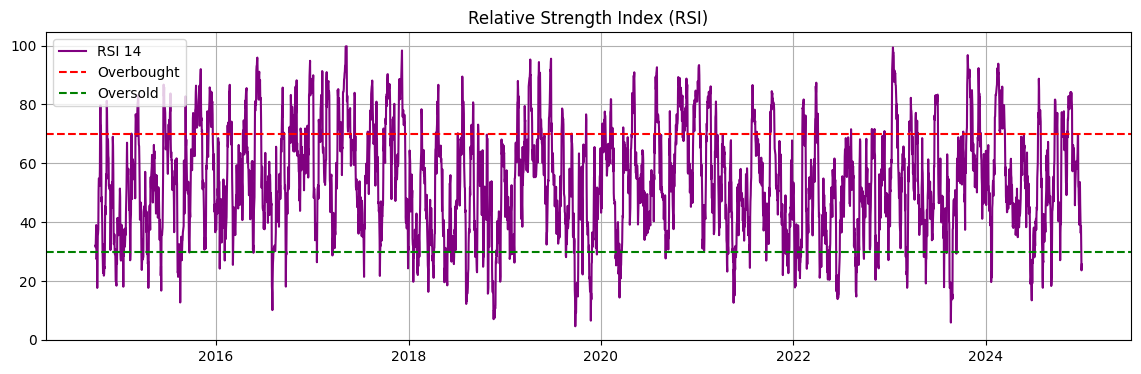

In [94]:
plt.figure(figsize=(14, 4))
plt.plot(btc_full['rsi_14'], label='RSI 14', color='purple')
plt.axhline(70, linestyle='--', color='red', label='Overbought')
plt.axhline(30, linestyle='--', color='green', label='Oversold')
plt.title('Relative Strength Index (RSI)')
plt.legend()
plt.grid(True)
plt.show()

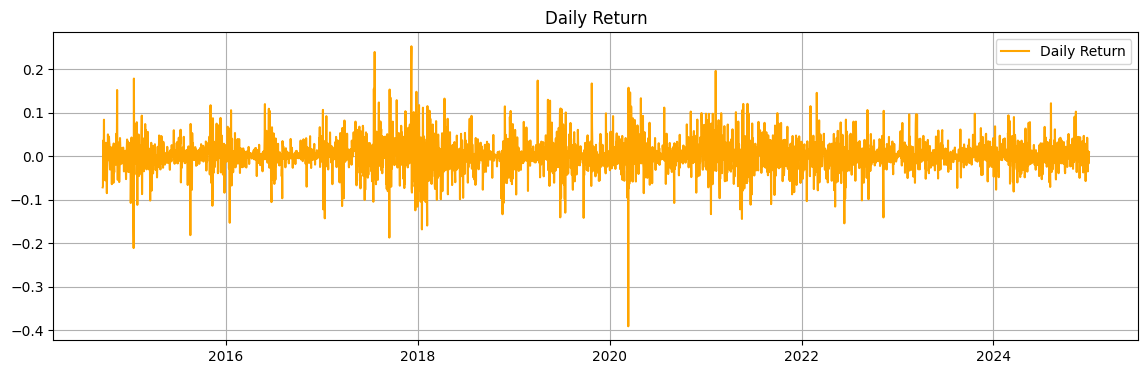

In [95]:
plt.figure(figsize=(14, 4))
plt.plot(btc_full['daily_return'], label='Daily Return', color='orange')
plt.title('Daily Return')
plt.grid(True)
plt.legend()
plt.show()

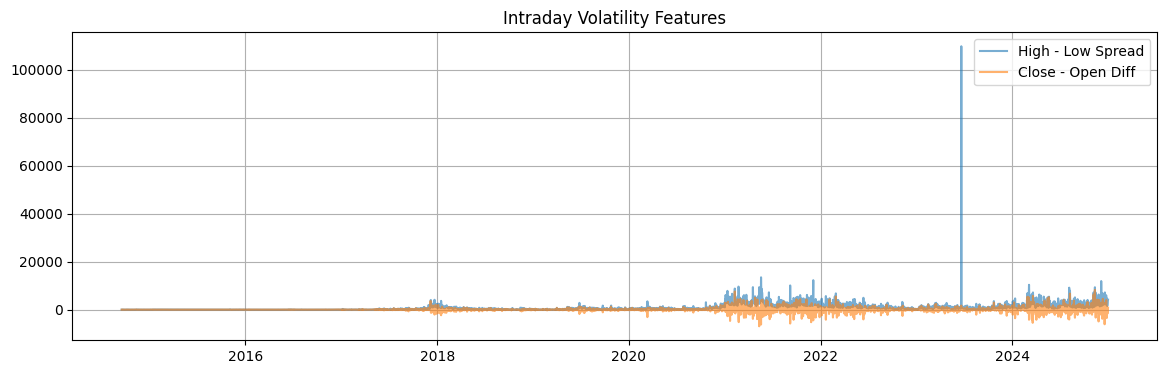

In [96]:
plt.figure(figsize=(14, 4))
plt.plot(btc_full['high_low_spread'], label='High - Low Spread', alpha=0.6)
plt.plot(btc_full['close_open_diff'], label='Close - Open Diff', alpha=0.6)
plt.title('Intraday Volatility Features')
plt.legend()
plt.grid(True)
plt.show()

In [97]:
btc_full = btc_full.ffill().bfill()

feature_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'sma_7', 'sma_21', 'ema_7', 'ema_21',
    'rsi_14', 'daily_return', 'high_low_spread', 'close_open_diff',
    'dayofweek', 'month', 'is_weekend'
]

btc_model = btc_full[feature_cols].copy()

In [98]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
btc_scaled = scaler.fit_transform(btc_model)

# Convert back to DataFrame to preserve index
btc_scaled = pd.DataFrame(btc_scaled, index=btc_model.index, columns=btc_model.columns)

btc_scaled.head()

,open,high,low,close,volume,sma_7,sma_21,ema_7,ema_21,rsi_14,daily_return,high_low_spread,close_open_diff,dayofweek,month,is_weekend
2014-09-17,0.002727,0.001860,0.002672,0.002635,0.000141,0.002073,0.001613,0.002342,0.002300,0.28789,0.496121,0.000143,0.457075,0.333333,0.727273,0.0
2014-09-18,0.002642,0.001778,0.002298,0.002325,0.000231,0.002073,0.001613,0.002262,0.002270,0.28789,0.496121,0.000398,0.455501,0.500000,0.727273,0.0
2014-09-19,0.002333,0.001568,0.002026,0.002045,0.000254,0.002073,0.001613,0.002130,0.002215,0.28789,0.499356,0.000394,0.455706,0.666667,0.727273,0.0
2014-09-20,0.002055,0.001535,0.002077,0.002178,0.000247,0.002073,0.001613,0.002066,0.002178,0.28789,0.663347,0.000304,0.458575,0.833333,0.727273,1.0
2014-09-21,0.002182,0.001456,0.002109,0.002083,0.000178,0.002073,0.001613,0.001993,0.002136,0.28789,0.569539,0.000175,0.457027,1.000000,0.727273,1.0
